In [1]:
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import cartopy.crs as ccrs
import cartopy.crs as crs
import cartopy.feature as cfeature
import h5py  
from astropy.time import Time
import os
import glob
from osgeo import gdal
import scipy.ndimage
import rasterio as rio
import re
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
from pyhdf.SD import SD, SDC
import pprint
import csv
import pprint
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable 

In [2]:
# Set input directory, and change working directory - plug in D:
inDir = "D:\\masters_data\\ATL08"   # I should change this so I can work from github?
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

In [3]:
# constants for conversion lat lon -> tile H,V and r,c
R = 6371007.181	    # the radius of the idealizes sphere representing the Earth
T = 1111950	        # the height and width of each MODIS tile in the projection plane
Xmin = -20015109    # the western limit of the projection plane
Ymax = 10007555	    # the northern limit of the projection plane
w = T/2400.0	    # the actual size of a '500m' MODIS sinusoidal grid cell. (would be /1200 for a 1km grid)

In [4]:
all_points = pd.read_csv("D:\\masters_data\\output\\csv\\all_points.txt")

In [5]:
# Filter out all rows for which the mean canopy height is higher than 1000m
all_points.drop(all_points[all_points['mean_height'] > 100].index, inplace = True) 

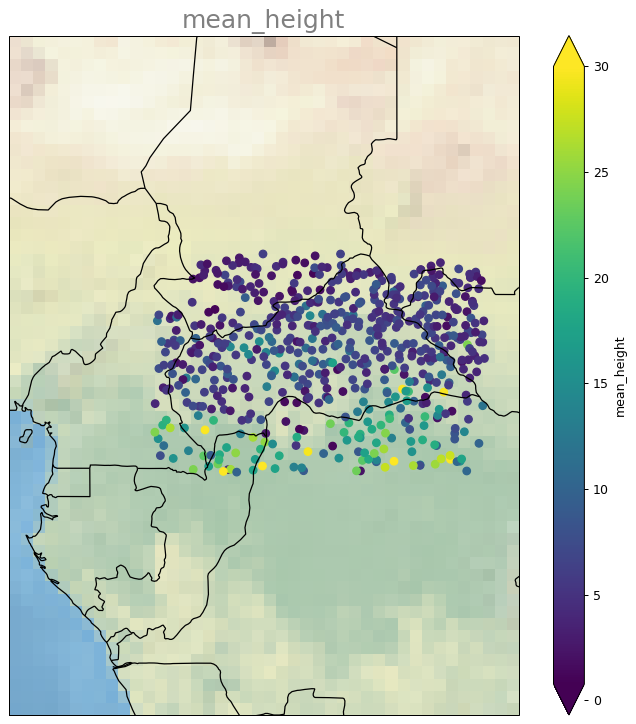

In [6]:
# plotting the data without the correcting for anomalies
variable = "mean_height"
mean_canopy_min = all_points["mean_height"].min()
mean_canopy_max = all_points["mean_height"].max()
vmin= mean_canopy_min
vmax= 30

ticks=np.arange(-20,100,5)

#size of image
plt.figure(figsize=(10,10), dpi= 90)

#coordinates / projection
ax = plt.axes(projection=crs.PlateCarree())

# / right /  /
lat1, lon1, lat2, lon2 = 8, 29, -8, 20
ax.set_extent([lat1, lon1, lat2, lon2], crs=crs.PlateCarree())

#background and design
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.stock_img()
ax.add_feature(cfeature.BORDERS)
ax.set_title('{}'.format(variable), fontsize = 20, color = 'gray')

#adding variable onto map (and colour bar)
plt.scatter(all_points['longitude'][::1000], all_points['latitude'][::1000],c=all_points[variable][::1000], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=variable, shrink=1, ticks=ticks,extend='both')

In [7]:
latitude = all_points['latitude'][:]
longitude = all_points['longitude'][:]
mean_height = all_points["mean_height"][:]

In [8]:
string_latitude = latitude.to_string(index = False)
string_latitude = latitude.replace("\n", ",")

string_longitude = longitude.to_string(index = False)
string_longitude = longitude.replace("\n", ",")

string_mean_height = mean_height.to_string(index = False)
string_mean_height = mean_height.replace("\n", ",")

In [9]:
float_latitude = [float(i) for i in string_latitude]
float_longitude = [float(i) for i in string_longitude]
float_mean_height = [float(i) for i in string_mean_height]

In [10]:
canopy_height_array = np.zeros((2400,2400))

In [66]:
# surely this isn't just this tile

In [11]:
number = 0
r_list = []
c_list = []
    
for i in latitude:
    lat = float_latitude[number]
    lon = float_longitude[number]
    phi = lat/(180/math.pi) # convert to radians
    lamb = lon/(180/math.pi)
    x = R*lamb*math.cos(phi)
    y = R*phi
    r = int(math.floor(((Ymax-y)%T)/w-0.5))
    c = int(math.floor(((x-Xmin)%T)/w-0.5))
    
    r_list.append(r)
    c_list.append(c)
    number += 1

In [12]:
for ii in range(len(r_list)):
    row = r_list[ii]
    col = c_list[ii]
    canopy_height_array[row, col] = float_mean_height[ii]

In [13]:
np.savetxt("D:\\masters_data\\output\\csv\\total_canopy_height_array_(meancanopyfile).csv", canopy_height_array, delimiter=",")

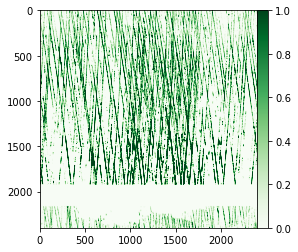

In [14]:
# shows where the ICESat-2 data has been

fig, axes = plt.subplots() 
img = axes.imshow(canopy_height_array,vmin=0, vmax=1, cmap = "Greens") 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img, cax = cax) 

plt.show()

# now need to create the different categories for analysis

In [15]:
# need to exclude 0 values from analysis

In [16]:
First_BA = pd.read_csv("D:\\masters_data\\output\\first_BA.csv")
Second_BA = pd.read_csv("D:\\masters_data\\output\\second_BA.csv")

In [17]:
Mask = np.zeros((2400, 2400))
# low_low / low_med / low_high

Mask[((First_BA<1) * (Second_BA<1))==1] = 1
Mask[((First_BA<1) * (Second_BA>=1) * (Second_BA<7))==1] = 2
Mask[((First_BA<1) * (Second_BA>=7))==1] = 3

# med_low / med_med / med_high
Mask[((First_BA>=1) * (First_BA<7) * (Second_BA<1))==1] = 4
Mask[((First_BA>=1) * (First_BA<7) * (Second_BA>=1) * (Second_BA<7))==1] = 5
Mask[((First_BA>=1) * (First_BA<7) * (Second_BA>=7))==1] = 6

#high_low / high_med / high_high
Mask[((Second_BA<1) * (First_BA>=7))==1] = 7
Mask[((First_BA>=7) * (Second_BA>=1) * (Second_BA<7))==1] = 8
Mask[((First_BA>=7) * (Second_BA>=7))==1] = 9

# this takes out where canopy height == 0, but means that the colormaps are hardly visible
# Mask[(canopy_height_array==0)==1]=0

In [18]:
low_low = np.zeros((2400, 2400))
low_med = np.zeros((2400, 2400))
low_high = np.zeros((2400, 2400))

med_low = np.zeros((2400, 2400))
med_med = np.zeros((2400, 2400))
med_high = np.zeros((2400, 2400))

high_low = np.zeros((2400, 2400))
high_med = np.zeros((2400, 2400))
high_high = np.zeros((2400, 2400))

In [19]:
low_low[Mask==1] = 1
low_med[Mask==2] = 1
low_high[Mask==3] = 1

med_low[Mask==4] = 1
med_med[Mask==5] = 1
med_high[Mask==6] = 1

high_low[Mask==7] = 1
high_med[Mask==8] = 1
high_high[Mask==9] = 1

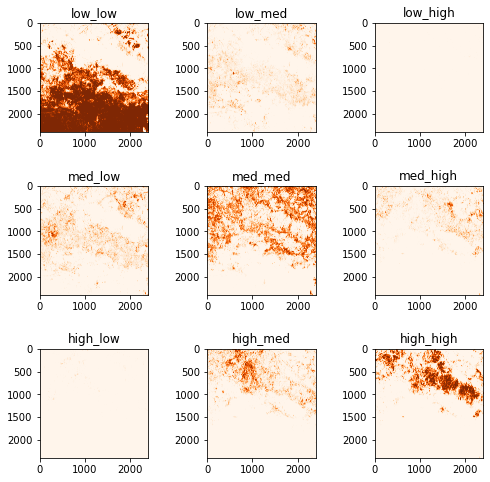

In [20]:
f, axs = plt.subplots(3,3,figsize=(8,8))

# low_low
plt.subplot(3,3,1)
color_map = plt.imshow(low_low)
plt.title("low_low")
img = axes.imshow(low_low, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# low_med
plt.subplot(3,3,2)
color_map = plt.imshow(low_med)
plt.title("low_med")
img = axes.imshow(low_med, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# low_high
plt.subplot(3,3,3)
color_map = plt.imshow(low_high)
plt.title("low_high")
img = axes.imshow(low_high, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# med_low
plt.subplot(3,3,4)
color_map = plt.imshow(med_low)
plt.title("med_low")
img = axes.imshow(med_low, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# med_med
plt.subplot(3,3,5)
color_map = plt.imshow(med_med)
plt.title("med_med")
img = axes.imshow(med_med, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# med_high
plt.subplot(3,3,6)
color_map = plt.imshow(med_high)
plt.title("med_high")
img = axes.imshow(med_high, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# high_low
plt.subplot(3,3,7)
color_map = plt.imshow(high_low)
plt.title("high_low")
img = axes.imshow(high_low, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# high_med
plt.subplot(3,3,8)
color_map = plt.imshow(high_med)
plt.title("high_med")
img = axes.imshow(high_med, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# high_high
plt.subplot(3,3,9)
color_map = plt.imshow(high_high)
plt.title("high_high")
img = axes.imshow(high_high, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

plt.subplots_adjust(wspace= 0.5, hspace = 0.5)
plt.show()

In [21]:
first_mask = np.zeros((2400, 2400))
second_mask = np.zeros((2400, 2400))

# first_low / first_med / first_high
first_mask[(First_BA<=1)==1] = 1
first_mask[((First_BA>=1) * (First_BA<7))==1] = 2
first_mask[(First_BA>7) ==1] = 3

# second_low / second_med / second_high
second_mask[(Second_BA<=1)==1] = 1
second_mask[((Second_BA>=1) * (First_BA<7))==1] = 2
second_mask[(Second_BA>7) ==1] = 3

# first_mask[(canopy_height_array==0)==1]=0
# second_mask[(canopy_height_array==0)==1]=0

In [22]:
first_low = np.zeros((2400, 2400))
first_med = np.zeros((2400, 2400))
first_high = np.zeros((2400, 2400))

second_low = np.zeros((2400, 2400))
second_med = np.zeros((2400, 2400))
second_high = np.zeros((2400, 2400))

In [23]:
first_low[first_mask==1] = 1
first_med[first_mask==2] = 1
first_high[first_mask==3] = 1

second_low[second_mask==1] = 1
second_med[second_mask==2] = 1
second_high[second_mask==3] = 1

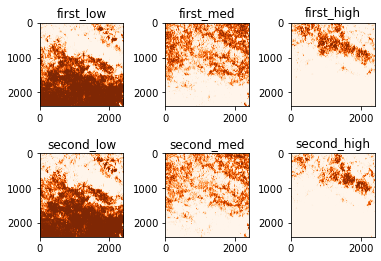

In [24]:
# first_low
plt.subplot(2,3,1)
color_map = plt.imshow(first_low)
plt.title("first_low")
img = axes.imshow(first_low, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# first_med
plt.subplot(2,3,2)
color_map = plt.imshow(first_med)
plt.title("first_med")
img = axes.imshow(first_med, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# first_high
plt.subplot(2,3,3)
color_map = plt.imshow(first_high)
plt.title("first_high")
img = axes.imshow(first_high, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# second_low
plt.subplot(2,3,4)
color_map = plt.imshow(second_low)
plt.title("second_low")
img = axes.imshow(second_low, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# second_med
plt.subplot(2,3,5)
color_map = plt.imshow(second_med)
plt.title("second_med")
img = axes.imshow(second_med, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# second_high
plt.subplot(2,3,6)
color_map = plt.imshow(second_high)
plt.title("second_high")
img = axes.imshow(second_high, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")
fig.subplots_adjust(right=0.8)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)

plt.subplots_adjust(wspace= 0.5, hspace = 0.5)
plt.show()

shows what we would expect - unfortunately there isn't much of an overlap
Need to do this for NDVI
Need to count low_low etc


In [25]:
#redone without where canopy=0

Mask_nocanopy = np.zeros((2400, 2400))
# low_low / low_med / low_high

Mask_nocanopy[((First_BA<1) * (Second_BA<1))==1] = 1
Mask_nocanopy[((First_BA<1) * (Second_BA>=1) * (Second_BA<7))==1] = 2
Mask_nocanopy[((First_BA<1) * (Second_BA>=7))==1] = 3

# med_low / med_med / med_high
Mask_nocanopy[((First_BA>=1) * (First_BA<7) * (Second_BA<1))==1] = 4
Mask_nocanopy[((First_BA>=1) * (First_BA<7) * (Second_BA>=1) * (Second_BA<7))==1] = 5
Mask_nocanopy[((First_BA>=1) * (First_BA<7) * (Second_BA>=7))==1] = 6

#high_low / high_med / high_high
Mask_nocanopy[((Second_BA<1) * (First_BA>=7))==1] = 7
Mask_nocanopy[((First_BA>=7) * (Second_BA>=1) * (Second_BA<7))==1] = 8
Mask_nocanopy[((First_BA>=7) * (Second_BA>=7))==1] = 9

# this takes out where canopy height == 0, but means that the colormaps are hardly visible
Mask_nocanopy[(canopy_height_array==0)==1]=0

In [26]:
print("Number of pixels in each category")
print()
print("\t\t W canopy=0 \t w/o canopy=0 ")
print("Low-low:\t {0}\t {1}".format(np.count_nonzero(Mask == 1),np.count_nonzero(Mask_nocanopy == 1)))
print("Low-med:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 2),np.count_nonzero(Mask_nocanopy == 2)))
print("Low-high:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 3),np.count_nonzero(Mask_nocanopy == 3)))
print("med-low:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 4),np.count_nonzero(Mask_nocanopy == 4)))
print("med-med:\t {0}\t {1}".format(np.count_nonzero(Mask == 5),np.count_nonzero(Mask_nocanopy == 5)))
print("med-med:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 6),np.count_nonzero(Mask_nocanopy == 6)))
print("high-low:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 7),np.count_nonzero(Mask_nocanopy == 7)))
print("high-med:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 8),np.count_nonzero(Mask_nocanopy == 8)))
print("high-high\t {0}\t\t {1}".format(np.count_nonzero(Mask == 9),np.count_nonzero(Mask_nocanopy == 9)))

Number of pixels in each category

		 W canopy=0 	 w/o canopy=0 
Low-low:	 2780864	 60037
Low-med:	 245663		 6715
Low-high:	 473		 17
med-low:	 393200		 12725
med-med:	 1073281	 39072
med-med:	 188463		 7885
high-low:	 5075		 208
high-med:	 383247		 16427
high-high	 689734		 32441


Now I want to calculate the mean tree canopy height (for w/o canopy=0)

In [27]:
low_low_canopy = np.zeros((2400, 2400))
low_low_canopy[low_low_canopy ==0] = np.nan

low_med_canopy = np.zeros((2400, 2400))
low_med_canopy[low_med_canopy ==0] = np.nan

low_high_canopy = np.zeros((2400, 2400))
low_high_canopy[low_high_canopy ==0] = np.nan

med_low_canopy = np.zeros((2400, 2400))
med_low_canopy[med_low_canopy ==0] = np.nan

med_med_canopy = np.zeros((2400, 2400))
med_med_canopy[med_med_canopy ==0] = np.nan

med_high_canopy = np.zeros((2400, 2400))
med_high_canopy[med_high_canopy ==0] = np.nan

high_low_canopy = np.zeros((2400, 2400))
high_low_canopy[high_low_canopy ==0] = np.nan

high_med_canopy = np.zeros((2400, 2400))
high_med_canopy[high_med_canopy ==0] = np.nan

high_high_canopy = np.zeros((2400, 2400))
high_high_canopy[high_high_canopy ==0] = np.nan

In [28]:
low_low_canopy[Mask_nocanopy == 1] = canopy_height_array[Mask_nocanopy == 1]
low_med_canopy[Mask_nocanopy == 2] = canopy_height_array[Mask_nocanopy == 2]
low_high_canopy[Mask_nocanopy == 3] = canopy_height_array[Mask_nocanopy == 3]

med_low_canopy[Mask_nocanopy == 4] = canopy_height_array[Mask_nocanopy == 4]
med_med_canopy[Mask_nocanopy == 5] = canopy_height_array[Mask_nocanopy == 5]
med_high_canopy[Mask_nocanopy == 6] = canopy_height_array[Mask_nocanopy == 6]

high_low_canopy[Mask_nocanopy == 7] = canopy_height_array[Mask_nocanopy == 7]
high_med_canopy[Mask_nocanopy == 8] = canopy_height_array[Mask_nocanopy == 8]
high_high_canopy[Mask_nocanopy == 9] = canopy_height_array[Mask_nocanopy == 9]

In [29]:
print("Number of pixels in each category")
print()
print("\t\t All land types  only savannah \t mean canopy")
print("Low-low:\t {0}\t {1}\t\t {2}".format(np.count_nonzero(Mask == 1),np.count_nonzero(Mask_nocanopy == 1), round(np.nanmean(low_low_canopy), 4)))
print("Low-med:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 2),np.count_nonzero(Mask_nocanopy == 2), round(np.nanmean(low_med_canopy), 4)))
print("Low-high:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 3),np.count_nonzero(Mask_nocanopy == 3), round(np.nanmean(low_high_canopy),4 )))
print("med-low:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 4),np.count_nonzero(Mask_nocanopy == 4), round(np.nanmean(med_low_canopy), 4)))
print("med-med:\t {0}\t {1}\t\t {2}".format(np.count_nonzero(Mask == 5),np.count_nonzero(Mask_nocanopy == 5), round(np.nanmean(med_med_canopy), 4)))
print("med-high:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 6),np.count_nonzero(Mask_nocanopy == 6), round(np.nanmean(med_high_canopy), 4)))
print("high-low:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 7),np.count_nonzero(Mask_nocanopy == 7), round(np.nanmean(high_low_canopy), 4)))
print("high-med:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 8),np.count_nonzero(Mask_nocanopy == 8), round(np.nanmean(high_med_canopy), 4)))
print("high-high\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 9),np.count_nonzero(Mask_nocanopy == 9), round(np.nanmean(high_high_canopy),4)))

print()
decrease_ff = (np.count_nonzero(Mask == 4) + np.count_nonzero(Mask == 7) + np.count_nonzero(Mask == 8))
constant_ff = (np.count_nonzero(Mask == 1) + np.count_nonzero(Mask == 5) + np.count_nonzero(Mask == 9))
increase_ff = (np.count_nonzero(Mask == 2) + np.count_nonzero(Mask == 3) + np.count_nonzero(Mask == 6))
print("Total decrease: {}".format(decrease_ff))
print("Total constant: {}".format(constant_ff))
print("total increase: {}".format(increase_ff))

Number of pixels in each category

		 All land types  only savannah 	 mean canopy
Low-low:	 2780864	 60037		 11.0669
Low-med:	 245663		 6715		 8.5939
Low-high:	 473		 17		 6.1695
med-low:	 393200		 12725		 7.9752
med-med:	 1073281	 39072		 6.9284
med-high:	 188463		 7885		 6.6214
high-low:	 5075		 208		 7.3142
high-med:	 383247		 16427		 6.6259
high-high	 689734		 32441		 6.4392

Total decrease: 781522
Total constant: 4543879
total increase: 434599


In [30]:
decrease = round(((np.nanmean(med_low_canopy) + np.nanmean(high_low_canopy) + np.nanmean(high_med_canopy)) / 3), 4)
constant = round(((np.nanmean(low_low_canopy) + np.nanmean(med_med_canopy) + np.nanmean(high_high_canopy)) / 3), 4)
increase = round(((np.nanmean(low_med_canopy) + np.nanmean(low_high_canopy) + np.nanmean(med_high_canopy)) / 3), 4)

In [31]:
print("decrease: {}".format(decrease))
print("constant: {}".format(constant))
print("increase: {}".format(increase))

decrease: 7.3051
constant: 8.1448
increase: 7.1283


In [32]:
print("Mean Canopy Height")
print()
print("category\t mean canopy (m)")
print("Low-low:\t {0}".format(round(np.nanmean(low_low_canopy), 4)))
print("Low-med:\t {0}".format(round(np.nanmean(low_med_canopy), 4)))
print("Low-high:\t {0}".format(round(np.nanmean(low_high_canopy),4 )))
print("med-low:\t {0}".format(round(np.nanmean(med_low_canopy), 4)))
print("med-med:\t {0}".format(round(np.nanmean(med_med_canopy), 4)))
print("med-high:\t {0}".format(round(np.nanmean(med_high_canopy), 4)))
print("high-low:\t {0}".format(round(np.nanmean(high_low_canopy), 4)))
print("high-med:\t {0}".format(round(np.nanmean(high_med_canopy), 4)))
print("high-high\t {0}".format(round(np.nanmean(high_high_canopy),4)))

print()
print("decrease:\t {}".format(decrease))
print("constant:\t {}".format(constant))
print("increase:\t {}".format(increase))

Mean Canopy Height

category	 mean canopy (m)
Low-low:	 11.0669
Low-med:	 8.5939
Low-high:	 6.1695
med-low:	 7.9752
med-med:	 6.9284
med-high:	 6.6214
high-low:	 7.3142
high-med:	 6.6259
high-high	 6.4392

decrease:	 7.3051
constant:	 8.1448
increase:	 7.1283


In [60]:
change_mask = np.zeros((2400, 2400))

# decrease
change_mask[Mask == 4] = 1
change_mask[Mask == 7] = 1
change_mask[Mask == 8] = 1

# no change
change_mask[Mask == 1] = 2
change_mask[Mask == 5] = 2
change_mask[Mask == 9] = 2

# no change
change_mask[Mask == 2] = 3
change_mask[Mask == 3] = 3
change_mask[Mask == 6] = 3

In [64]:
change_cmap = colors.ListedColormap(["blue", "gainsboro", "red"])

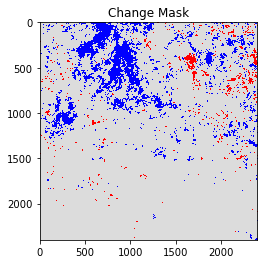

In [65]:
color_map = plt.imshow(change_mask)
plt.title("Change Mask")
img = axes.imshow(change_mask, cmap = change_cmap)
plt.colorbar(img, cax = cax)
color_map.set_cmap(change_cmap)
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")
color_bar = plt.colorbar(img, cax = cax) 
plt.show()